In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import pandas as pd
from PIL import Image

# DoubleConv Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# UNet Model Definition
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')  # Load as RGB
        mask = Image.open(self.mask_paths[idx]).convert('L')    # Load as grayscale (1 channel)

        if self.transform:
            img = self.transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask

# Load Dataset Metadata
def load_flood_dataset(metadata_path, image_dir, mask_dir):
    metadata = pd.read_csv(metadata_path)
    image_paths = [os.path.join(image_dir, img) for img in metadata['Image']]
    mask_paths = [os.path.join(mask_dir, mask) for mask in metadata['Mask']]
    return image_paths, mask_paths

# Training Function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    dice_score = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection = (preds * masks).sum()
            dice_score += (2. * intersection + 1e-6) / (preds.sum() + masks.sum() + 1e-6)
    return dice_score / len(dataloader)

# Main
if __name__ == "__main__":
    # Paths
    metadata_path = "E:\metadata.csv"
    image_dir = "E:\Image"
    mask_dir = "E:\Mask"

    # Parameters
    batch_size = 16
    lr = 1e-4
    num_epochs = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Dataset
    image_paths, mask_paths = load_flood_dataset(metadata_path, image_dir, mask_dir)

    # Define Transforms
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # For RGB images
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()  # No normalization for masks
    ])

    # Create DataLoader
    dataset = SegmentationDataset(image_paths, mask_paths, transform=transform, mask_transform=mask_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize Model
    model = UNET(in_channels=3, out_channels=1).to(device)

    # Loss and Optimizer
    criterion = nn.BCEWithLogitsLoss()  # Sigmoid is included in this loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train Model
    best_dice_score = 0
    best_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_model(model, dataloader, criterion, optimizer, device)
        dice_score = evaluate_model(model, dataloader, device)

        if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_loss = train_loss

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, DICE Score: {dice_score:.4f}")

    # Evaluate Model
    print(f"Final DICE Score: {best_dice_score:.4f} with Loss: {best_loss:.4f}")

<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\I'
<>:134: SyntaxWarning: invalid escape sequence '\M'
<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\I'
<>:134: SyntaxWarning: invalid escape sequence '\M'
C:\Users\User\AppData\Local\Temp\ipykernel_1508\230560011.py:132: SyntaxWarning: invalid escape sequence '\m'
  metadata_path = "E:\metadata.csv"
C:\Users\User\AppData\Local\Temp\ipykernel_1508\230560011.py:133: SyntaxWarning: invalid escape sequence '\I'
  image_dir = "E:\Image"
C:\Users\User\AppData\Local\Temp\ipykernel_1508\230560011.py:134: SyntaxWarning: invalid escape sequence '\M'
  mask_dir = "E:\Mask"


Epoch 1/100, Loss: 0.5237, DICE Score: 0.5898
Epoch 2/100, Loss: 0.4014, DICE Score: 0.7217
Epoch 3/100, Loss: 0.3685, DICE Score: 0.8207
Epoch 4/100, Loss: 0.3502, DICE Score: 0.8364
Epoch 5/100, Loss: 0.3393, DICE Score: 0.8313
Epoch 6/100, Loss: 0.3279, DICE Score: 0.8300
Epoch 7/100, Loss: 0.3275, DICE Score: 0.8568
Epoch 8/100, Loss: 0.3130, DICE Score: 0.8545
Epoch 9/100, Loss: 0.3041, DICE Score: 0.8585
Epoch 10/100, Loss: 0.2970, DICE Score: 0.8639
Epoch 11/100, Loss: 0.2998, DICE Score: 0.8741
Epoch 12/100, Loss: 0.2948, DICE Score: 0.8625
Epoch 13/100, Loss: 0.2931, DICE Score: 0.8289
Epoch 14/100, Loss: 0.2815, DICE Score: 0.8776
Epoch 15/100, Loss: 0.2832, DICE Score: 0.8745
Epoch 16/100, Loss: 0.2807, DICE Score: 0.8714
Epoch 17/100, Loss: 0.2861, DICE Score: 0.8714
Epoch 18/100, Loss: 0.2879, DICE Score: 0.8744
Epoch 19/100, Loss: 0.2776, DICE Score: 0.8787
Epoch 20/100, Loss: 0.2632, DICE Score: 0.8695
Epoch 21/100, Loss: 0.2606, DICE Score: 0.8798
Epoch 22/100, Loss: 0.

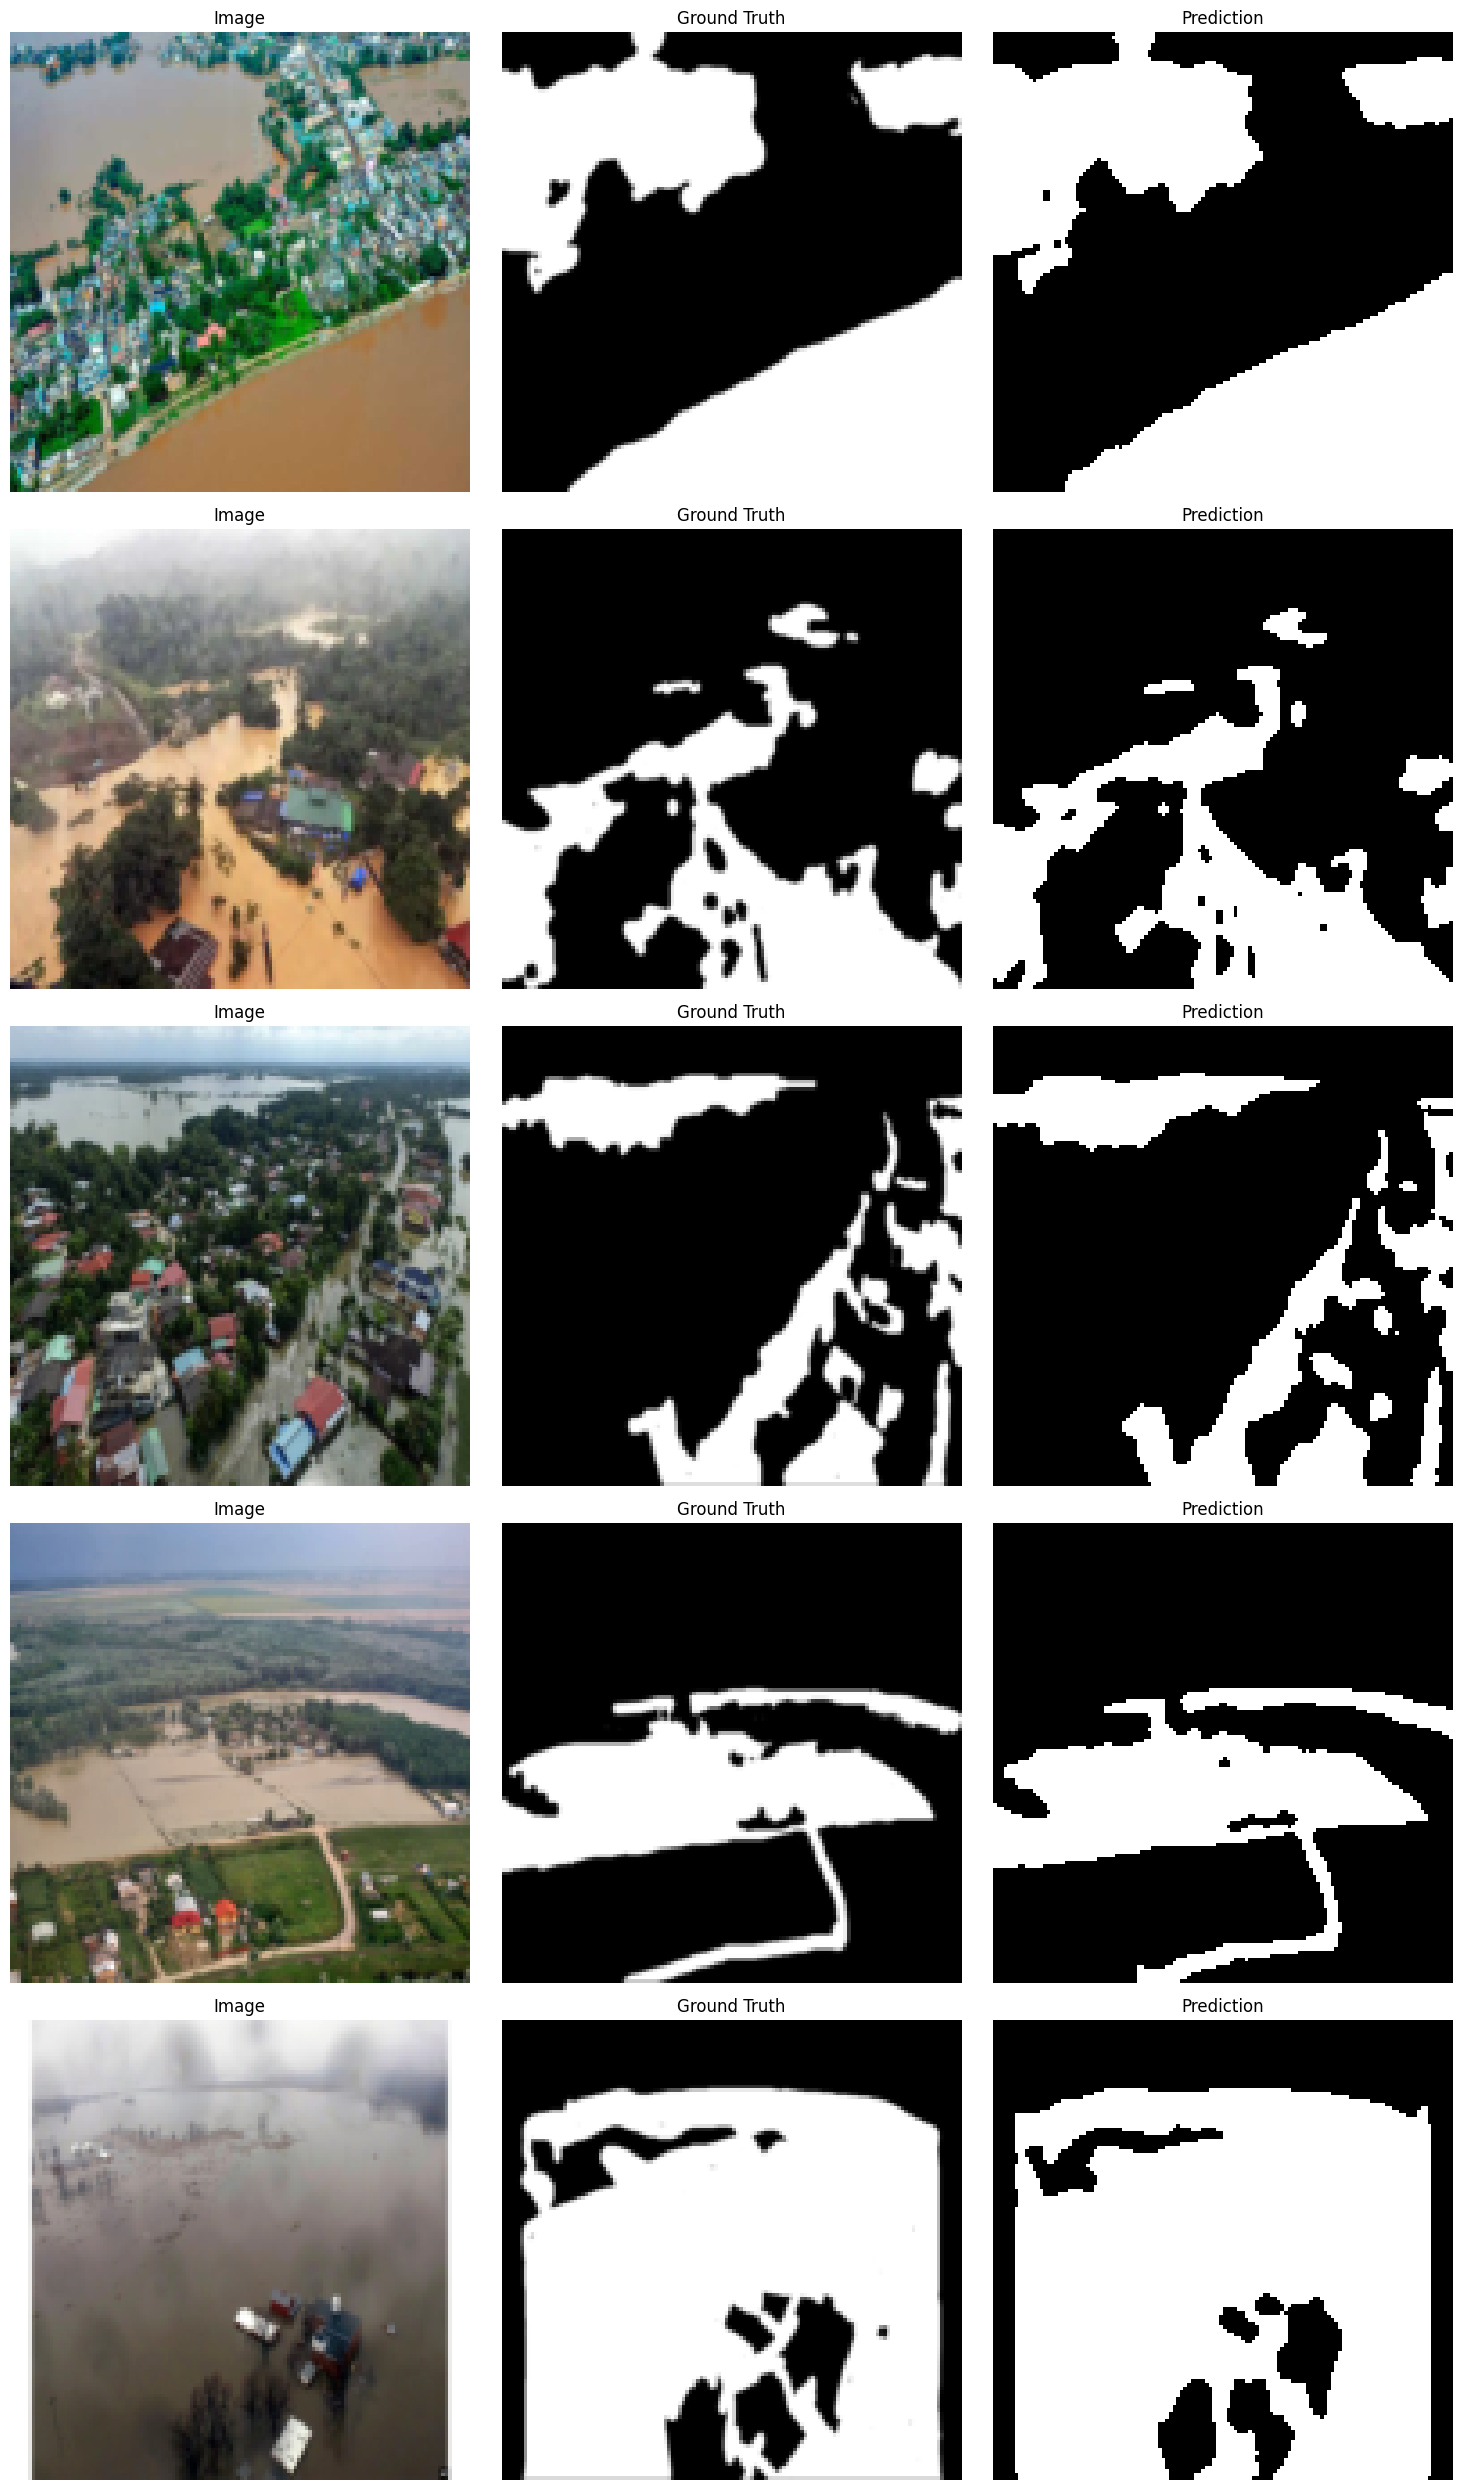

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, num_samples * 5))

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display

                mask = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()

                plt.subplot(num_samples, 3, images_shown * 3 + 1)
                plt.imshow(img)
                plt.title("Image")
                plt.axis("off")

                plt.subplot(num_samples, 3, images_shown * 3 + 2)
                plt.imshow(mask, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(num_samples, 3, images_shown * 3 + 3)
                plt.imshow(pred, cmap="gray")
                plt.title("Prediction")
                plt.axis("off")

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(model, dataloader, device, num_samples=5)
